In [103]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2
from pyrfu import mms
from pyrfu.plot import plot_line, plot_spectr
import matplotlib.gridspec as gridspec
from ne2fpe import ne2fpe
import matplotlib.pyplot as plt
plt.style.use('../msc-project/figstyle.mplstyle')
from matplotlib.font_manager import fontManager
fontManager.addfont('../msc-project/fonts/TIMES.TTF')
from pyrfu import pyrf
from matplotlib.cm import get_cmap
import logging
from scipy.optimize import curve_fit
import os
import csv
import numpy as np
from sw_density_from_fpe import sw_density_from_fpe

In [226]:
tint_example = ['2024-05-03T16:25:37.700272500', '2024-05-04T08:09:04.000000000']
ic = 1

In [227]:
ne, vsc_fitted, N0, beta, epsd_data_filt, vsc = sw_density_from_fpe(tint_example, ic, sw_mode=0)

[29-May-25 11:37:48] INFO: Loading mms1_edp_scpot_fast_l2...
[29-May-25 11:37:50] INFO: Loading mms1_dsp_epsd_omni...


[29-May-25 11:37:55] INFO: Loading mms1_des_numberdensity_fast...


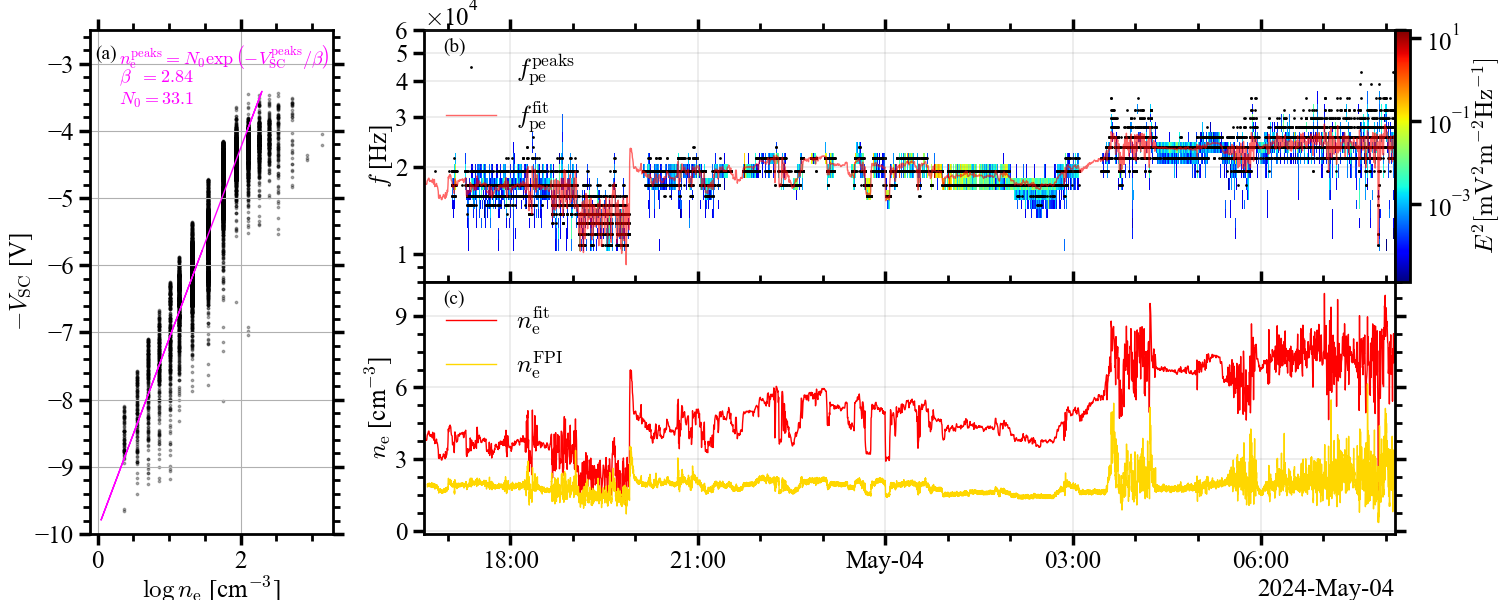

In [228]:
log_ne = np.log(ne)

ne_fit = N0 * np.exp(-vsc / beta)

ne_fpi_ = mms.get_data('ne_fpi_fast_l2', tint_example, ic)
ne_fpi = ne_fpi_.drop_duplicates(dim='time')
fpe_fit = ne2fpe(ne_fit)

# Plotting
plt.close('all')
fig = plt.figure(figsize=(15, 6))


gs = gridspec.GridSpec(2, 2, width_ratios=[0.2, 0.8], hspace=0, wspace=0.15, left=0.06, right=0.93, top=0.95, bottom=0.11)
ax_fit = fig.add_subplot(gs[:, 0])
ax_spectrum = fig.add_subplot(gs[0, 1])
ax_density = fig.add_subplot(gs[1, 1], sharex=ax_spectrum)

# Linear fit result and data points
# hist2d = ax_fit.hist2d(log_ne, -vsc_fitted, bins = [np.unique(log_ne.data), 100], cmap='jet', cmin=10)
ax_fit.scatter(log_ne, -vsc_fitted, color='black', alpha=0.3, s=3)
ax_fit.plot(np.log(ne_fit), -vsc, color='magenta', linewidth=1)
ax_fit.set_xlabel(r'$\log n_\mathrm{e}$ [cm$^{-3}$]')
ax_fit.set_ylabel(r'$-V_\mathrm{SC}$ [V]')
ax_fit.text(0.12, 0.975, r'$n_\mathrm{e}^\mathrm{peaks} = N_0 \exp \left(-V_\mathrm{SC}^\mathrm{peaks} / \beta \right)$', 
            transform=ax_fit.transAxes, color='magenta', fontsize=13, horizontalalignment='left', verticalalignment='top')
ax_fit.text(0.12, 0.925, fr'$\beta\ \  = {beta:.2f}$'+'\n'+fr'$N_0 = {N0:.1f}$', 
            transform=ax_fit.transAxes, color='magenta', fontsize=13, horizontalalignment='left', verticalalignment='top')
ax_fit.grid(1)
ax_fit.set_ylim(-10, -2.5)

# Spectral data and final fpe overlaid
ax_s, ax_c = plot_spectr(ax_spectrum, epsd_data_filt, clim='auto', yscale='log', cscale='log', cmap='jet')
plot_line(ax_s, ne2fpe(ne), color='black', ls='', marker='.', markerfacecolor='none', markersize=2, label=r'$f_\mathrm{pe}^\mathrm{peaks}$')
plot_line(ax_s,fpe_fit, color='red', alpha=0.6, linewidth=1, label=r'$f_\mathrm{pe}^\mathrm{fit}$')
ax_s.legend(fontsize=18, loc='upper left', ncols=1, frameon=False)
ax_s.set_ylabel(r'$f$ [Hz]')
ax_s.set_ylim(8e3, 6e4)
ax_s.set_xlim(epsd_data_filt.time.data[0], epsd_data_filt.time.data[-1])
ax_c.set_ylabel(r'$E^2 \mathrm{[mV^2 m^{-2} Hz^{-1}]}$')

class IntScalarFormatter(plt.ScalarFormatter):
    def _set_format(self):
        self.format = "%d"  # Only integers

maj_locs = ax_s.xaxis.get_majorticklocs()
minor_locs = []
for i in range(len(maj_locs) - 1):
    start, end = maj_locs[i], maj_locs[i + 1]
    spacing = (end - start) / 3  # divide into 3 segments
    minor_locs.append(start + spacing)
    minor_locs.append(start + 2 * spacing)
    if i==0:
        minor_locs.append(start - spacing)
        
minor_locs.append(end + spacing)
minor_locs.append(end + 2*spacing)


# Set minor tick locations
ax_s.xaxis.set_minor_locator(plt.FixedLocator(minor_locs))

ax_s.yaxis.set_major_locator(plt.LogLocator(base=10.0, subs=[1,2,3,4,5,6], numticks=10))

formatter = IntScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((4, 5))
ax_s.yaxis.set_major_formatter(formatter)

spos = ax_s.get_position()
ax_c.set_position([spos.x1, spos.y0, 0.01, spos.height])


# Obtained density and FPI density
plot_line(ax_density, ne_fit, color='red', alpha=1, linewidth=1, label=r'$n_\mathrm{e}^\mathrm{fit}$')
plot_line(ax_density, ne_fpi, color='gold', alpha=1, linewidth=1, label=r'$n_\mathrm{e}^\mathrm{FPI}$')
ax_density.legend(fontsize=18, loc='upper left', ncols=1, frameon=False)
ax_density.set_ylabel(r'$n_\mathrm{e}$ [cm$^{-3}$]')

for i, ax in enumerate([ax_fit, ax_s, ax_density]):
    ax.text(0.02, 0.97, f'({['a', 'b', 'c'][i]})', fontsize=14,transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')


fig.savefig('figures/thesis/method_example_20240504.png', dpi=300)

In [229]:
epsd_data = mms.db_get_ts(f'mms{ic}_dsp_fast_l2_epsd',f'mms{ic}_dsp_epsd_omni', tint_example)

[29-May-25 11:37:58] INFO: Loading mms1_dsp_epsd_omni...


In [230]:
pyrf.calc_fs(epsd_data)

0.49999323834144127